In [1]:
import sys
sys.path.append('../src/')

# Import and Format Data

In [2]:
from pandas import read_csv, to_datetime, concat
from numpy import where

holidays_data = read_csv('../data/holiday_17_18_19.csv - holiday_17_18_19.csv')
holidays = list(to_datetime(holidays_data["Date"], format='%d.%m.%Y'))
meteo_data = read_csv('../data/IST_meteo_data_2017_2018_2019.csv - IST_meteo_data_2017_2018_2019.csv')
building_data_2017 = read_csv('../data/IST_South_Tower_2017_Ene_Cons.csv')
building_data_2018 = read_csv('../data/IST_South_Tower_2018_Ene_Cons.csv')

# set index
meteo_data['yyyy-mm-dd hh:mm:ss'] = to_datetime(meteo_data['yyyy-mm-dd hh:mm:ss'], format='%Y-%m-%d %H:%M:%S')
meteo_data = meteo_data.set_index('yyyy-mm-dd hh:mm:ss')
building_data_2017['Date_start'] = to_datetime(building_data_2017['Date_start'], format='%d-%m-%Y %H:%M')
building_data_2018['Date_start'] = to_datetime(building_data_2018['Date_start'], format='%d-%m-%Y %H:%M')
building_data_2017 = building_data_2017.set_index('Date_start')
building_data_2018 = building_data_2018.set_index('Date_start')
building_data = concat([building_data_2017, building_data_2018])

# resample data and combine into one dataframe
meteo_data_resample = meteo_data.resample('H', closed='right', label='right')[
    'temp_C', 'HR', 'windSpeed_m/s', 'windGust_m/s', 'pres_mbar',
    'solarRad_W/m2', 'rain_mm/h'].mean()
meteo_data_resample["rain_day"] = meteo_data.resample('H', closed='right', label='right')['rain_day'].max()
df = building_data.join(meteo_data_resample)
df['holiday'] = where(df.index.to_period('D').astype('datetime64[ns]').isin(holidays), 1, 0)

# Data Analysis

## First look at Timeseries

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,rain_day,holiday
2017-01-01 00:00:00,100.810001,8.720000,74.600000,2.138000,3.774000,1029.000000,1.163000,0.0,0.0,1
2017-01-01 01:00:00,99.054135,8.490000,75.000000,2.335833,3.228833,1029.000000,1.371250,0.0,0.0,1
2017-01-01 02:00:00,98.539567,7.877500,76.658333,2.776250,3.501250,1028.083333,1.581250,0.0,0.0,1
2017-01-01 03:00:00,101.435784,7.212417,80.441667,3.384083,4.193000,1028.000000,1.318083,0.0,0.0,1
2017-01-01 04:00:00,98.481664,6.817083,81.300000,3.490667,4.360667,1028.000000,1.569750,0.0,0.0,1


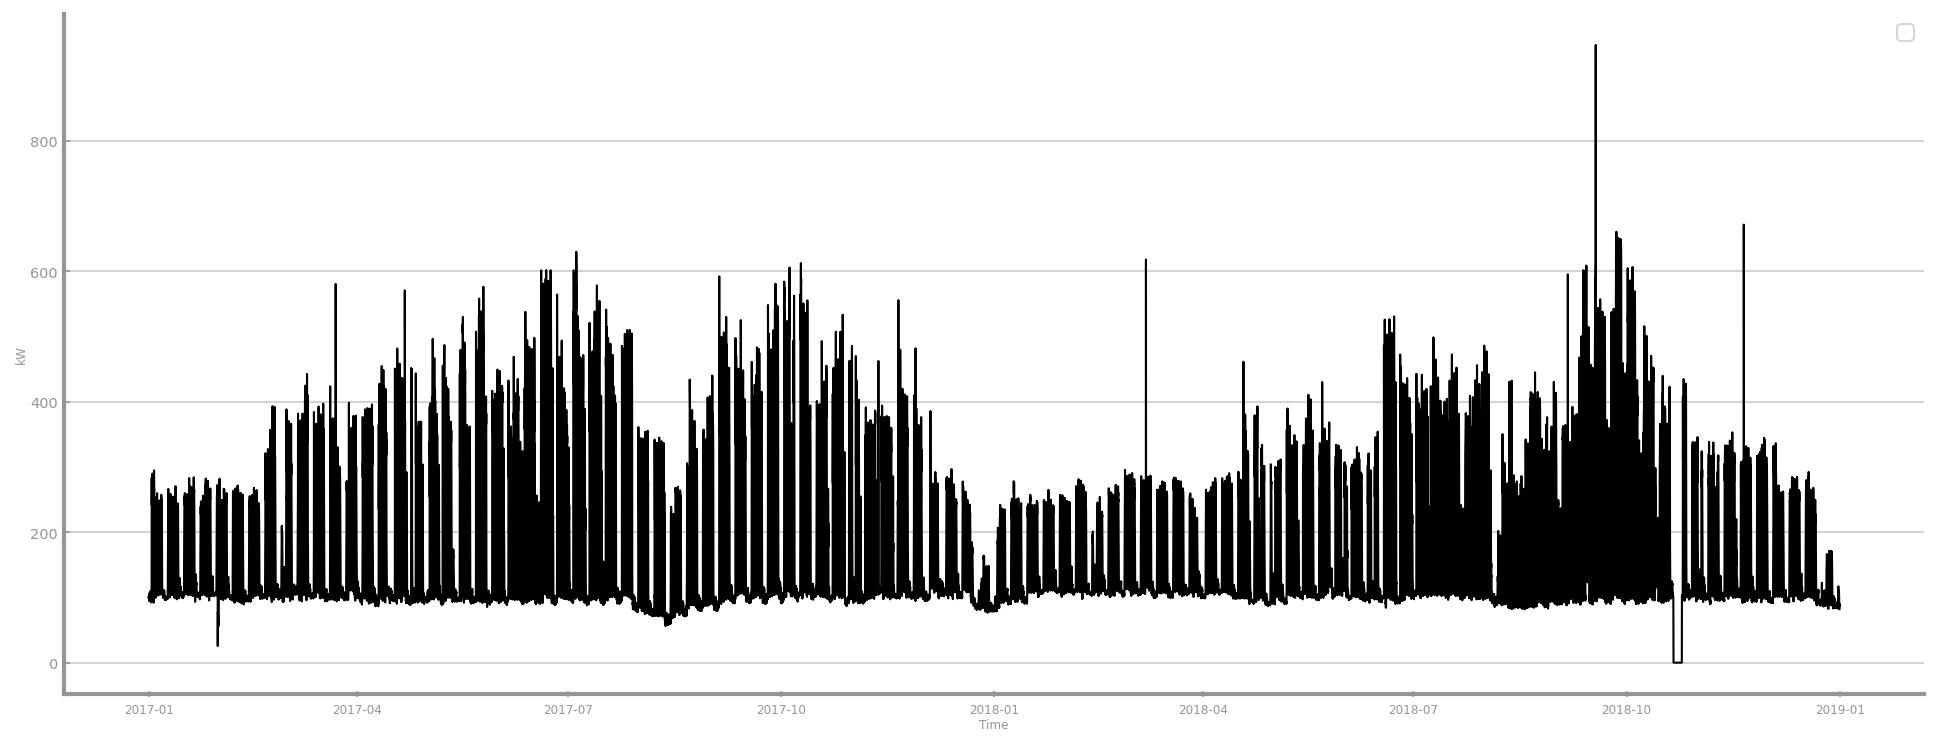

In [3]:
from ds_tools.profiling import plot_timeseries

plot_timeseries(df, columns=['Power_kW'], y_labels=['kW'])
df.head()


## Missing Values

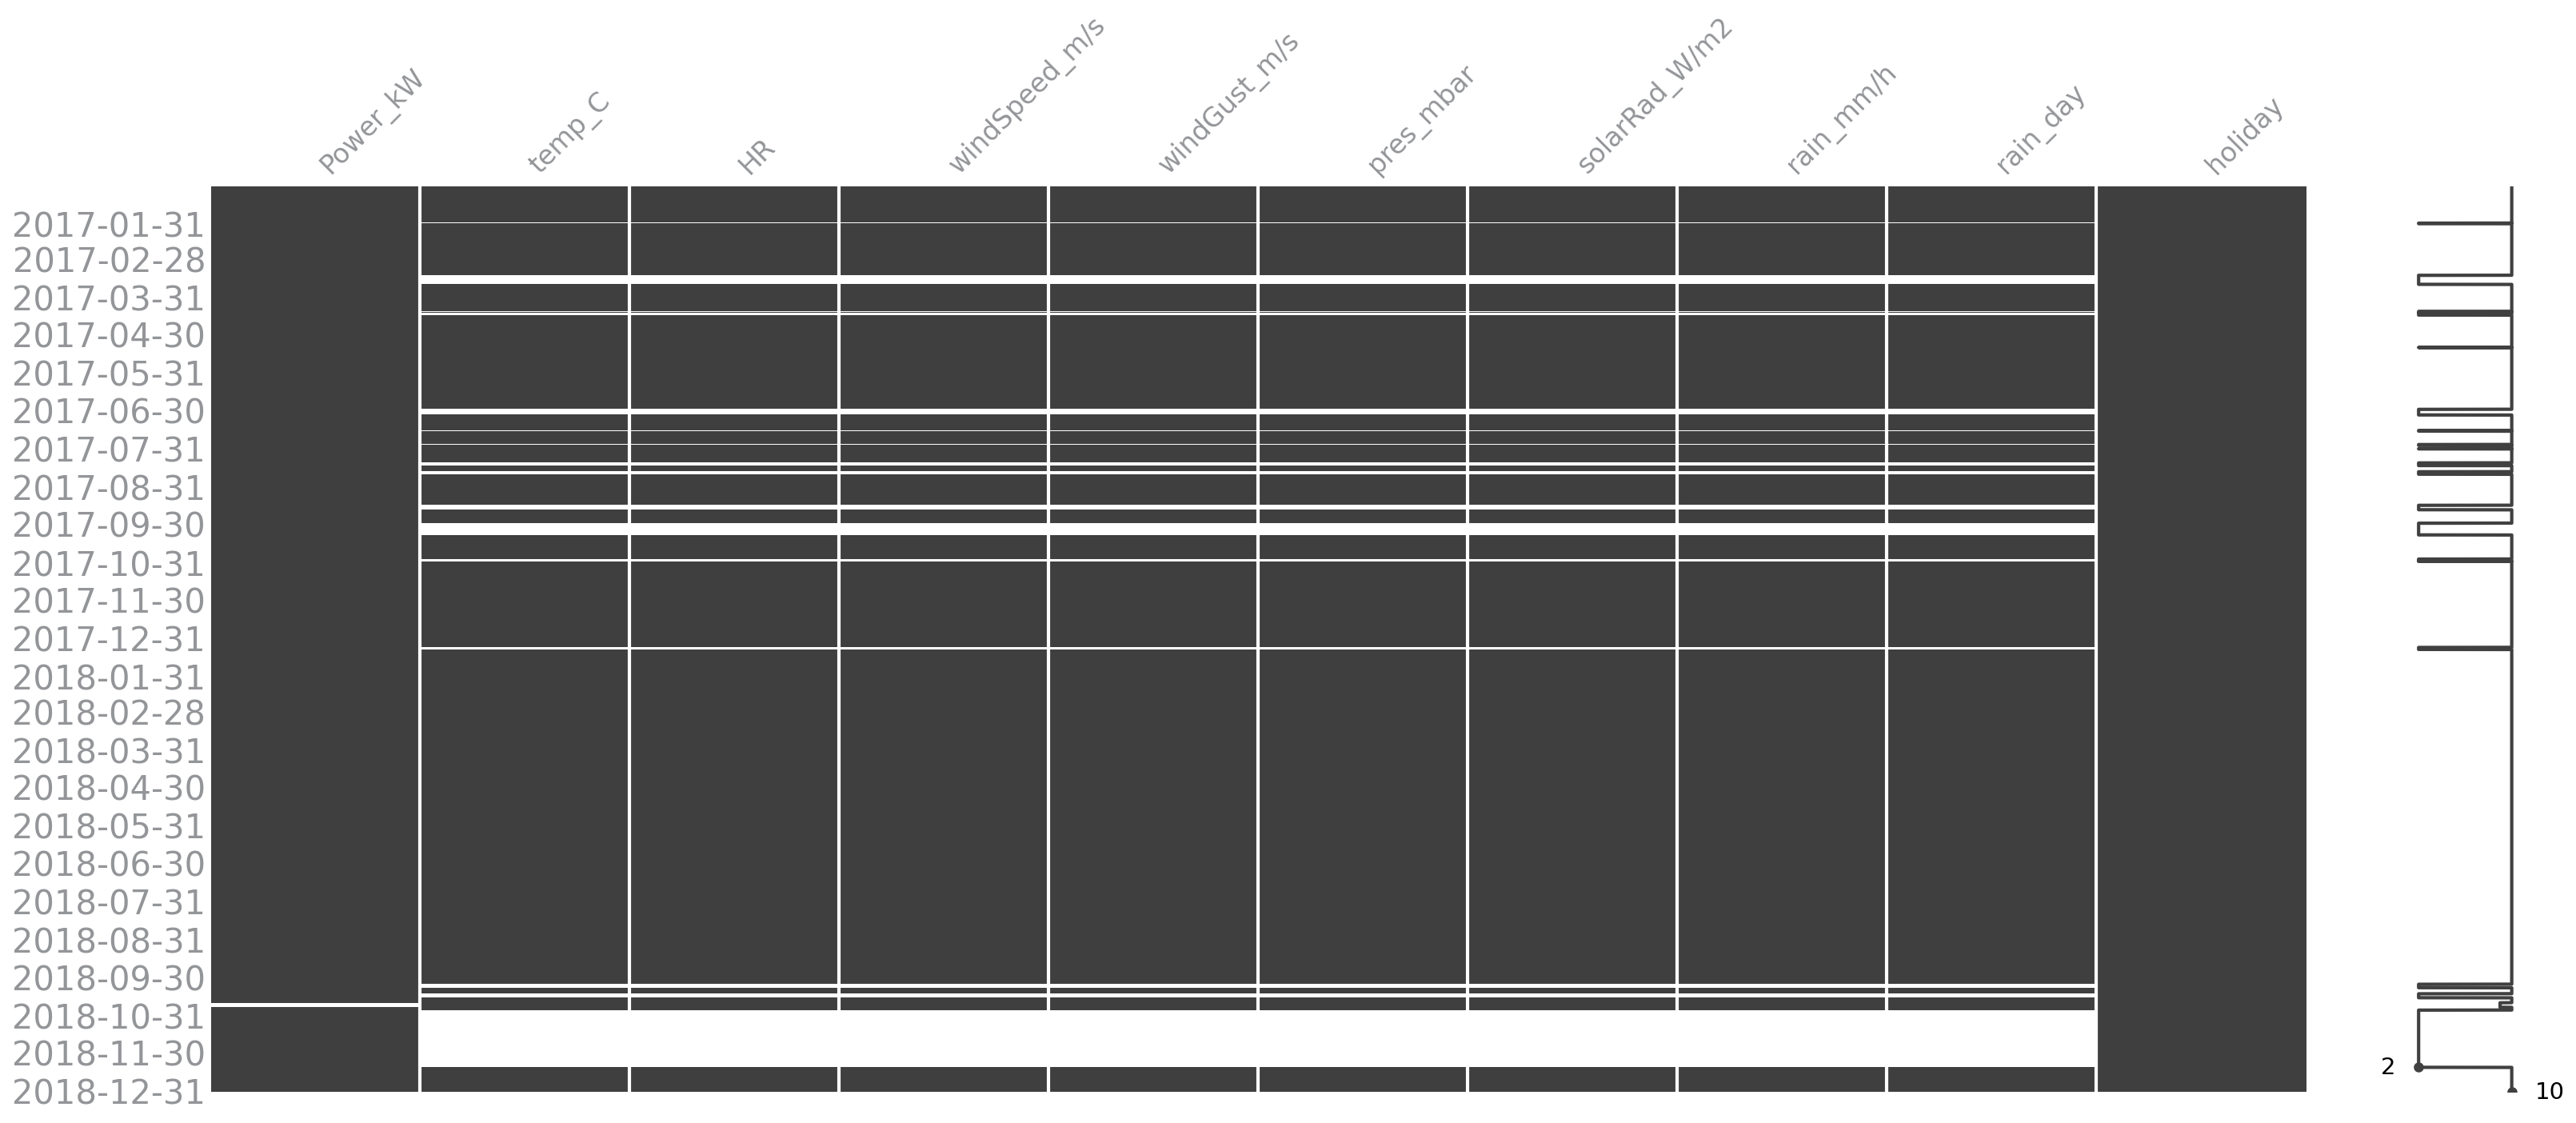

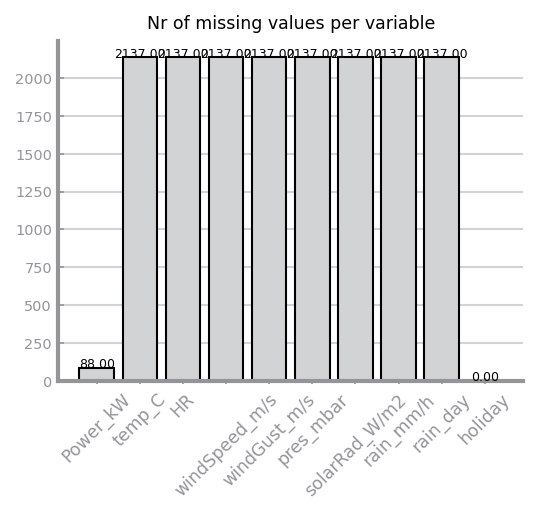

In [4]:
from missingno import matrix
from ds_tools.profiling import show_missing_values
from numpy import nan

df['Power_kW'].replace(0, nan, inplace=True)
matrix(df, freq='M')
show_missing_values(df)

## Fill Missing Values

To keep it simple, all missing values are imputed by 0.

In [5]:
df = df.fillna(0)

## Histogram and Correclation of Variables

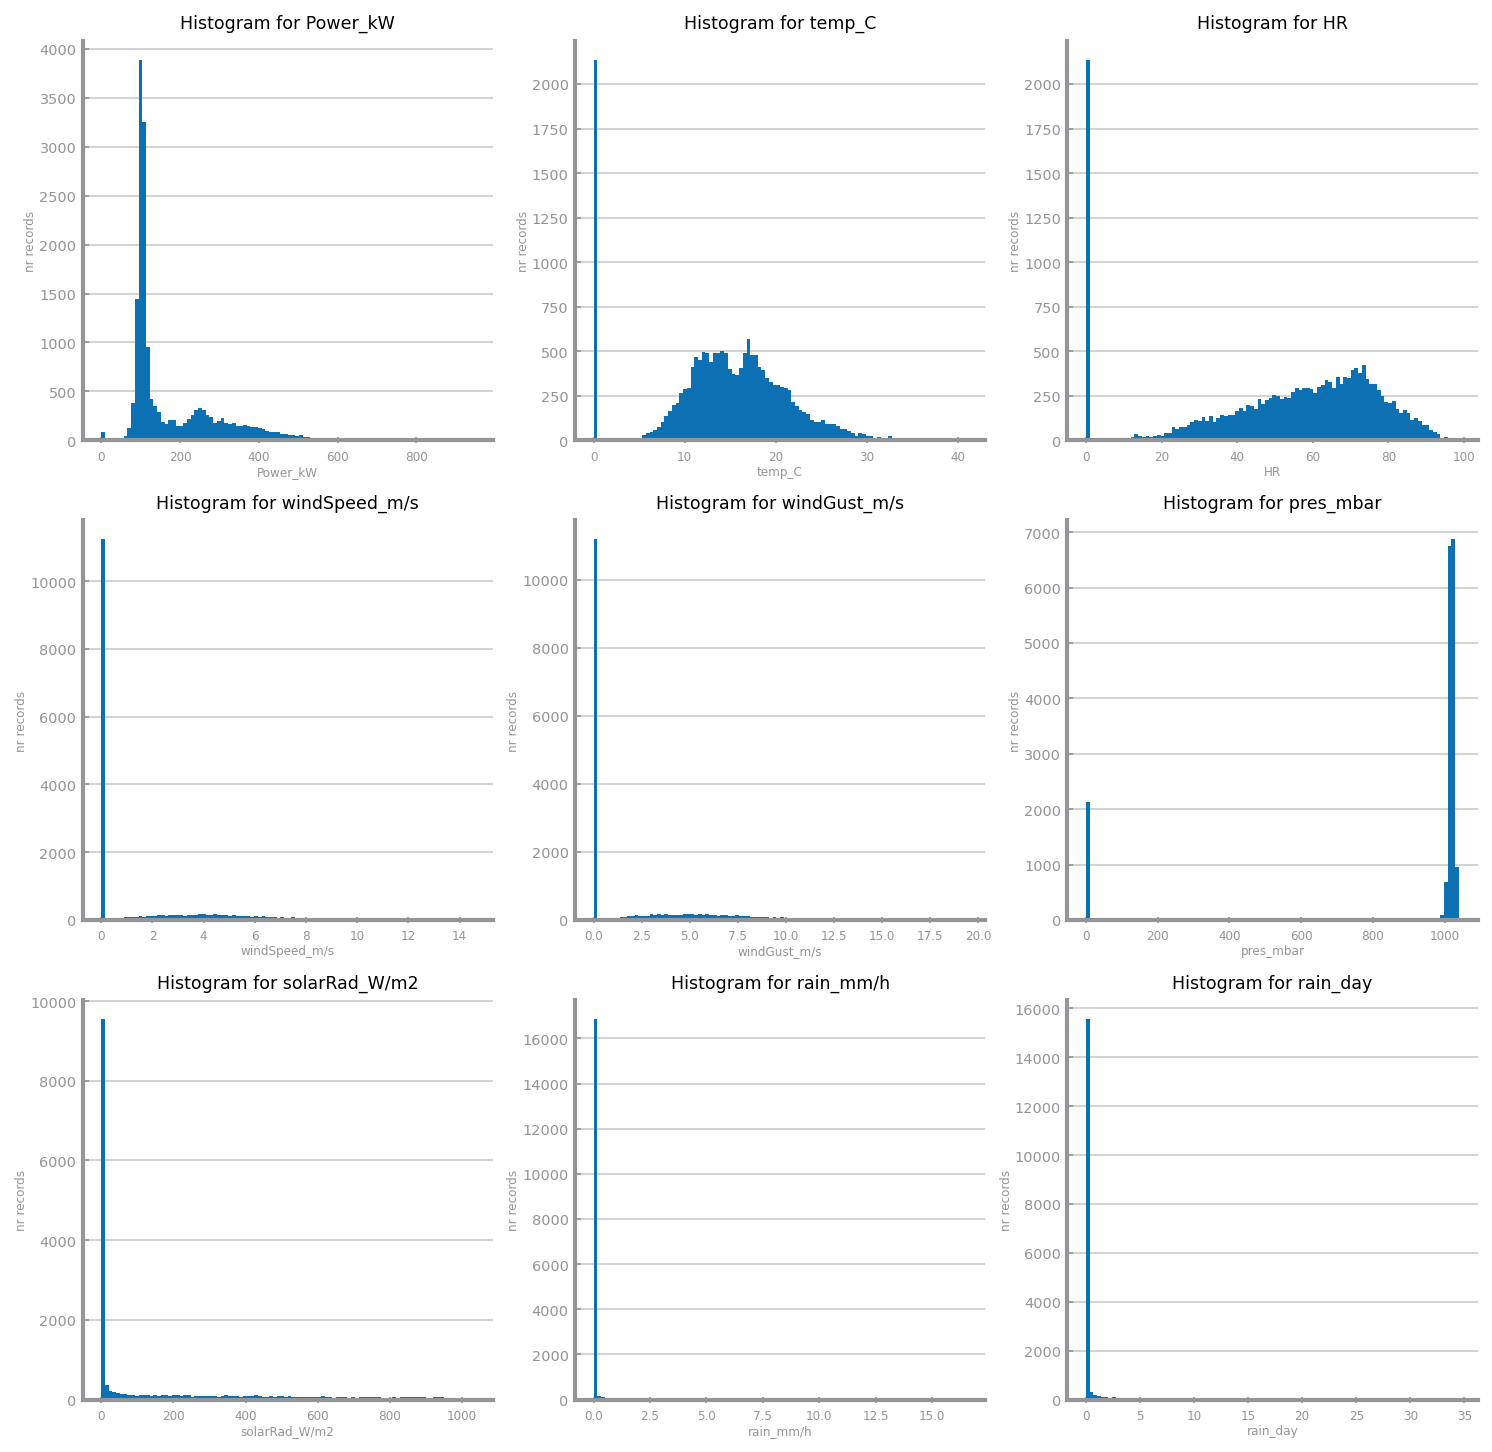

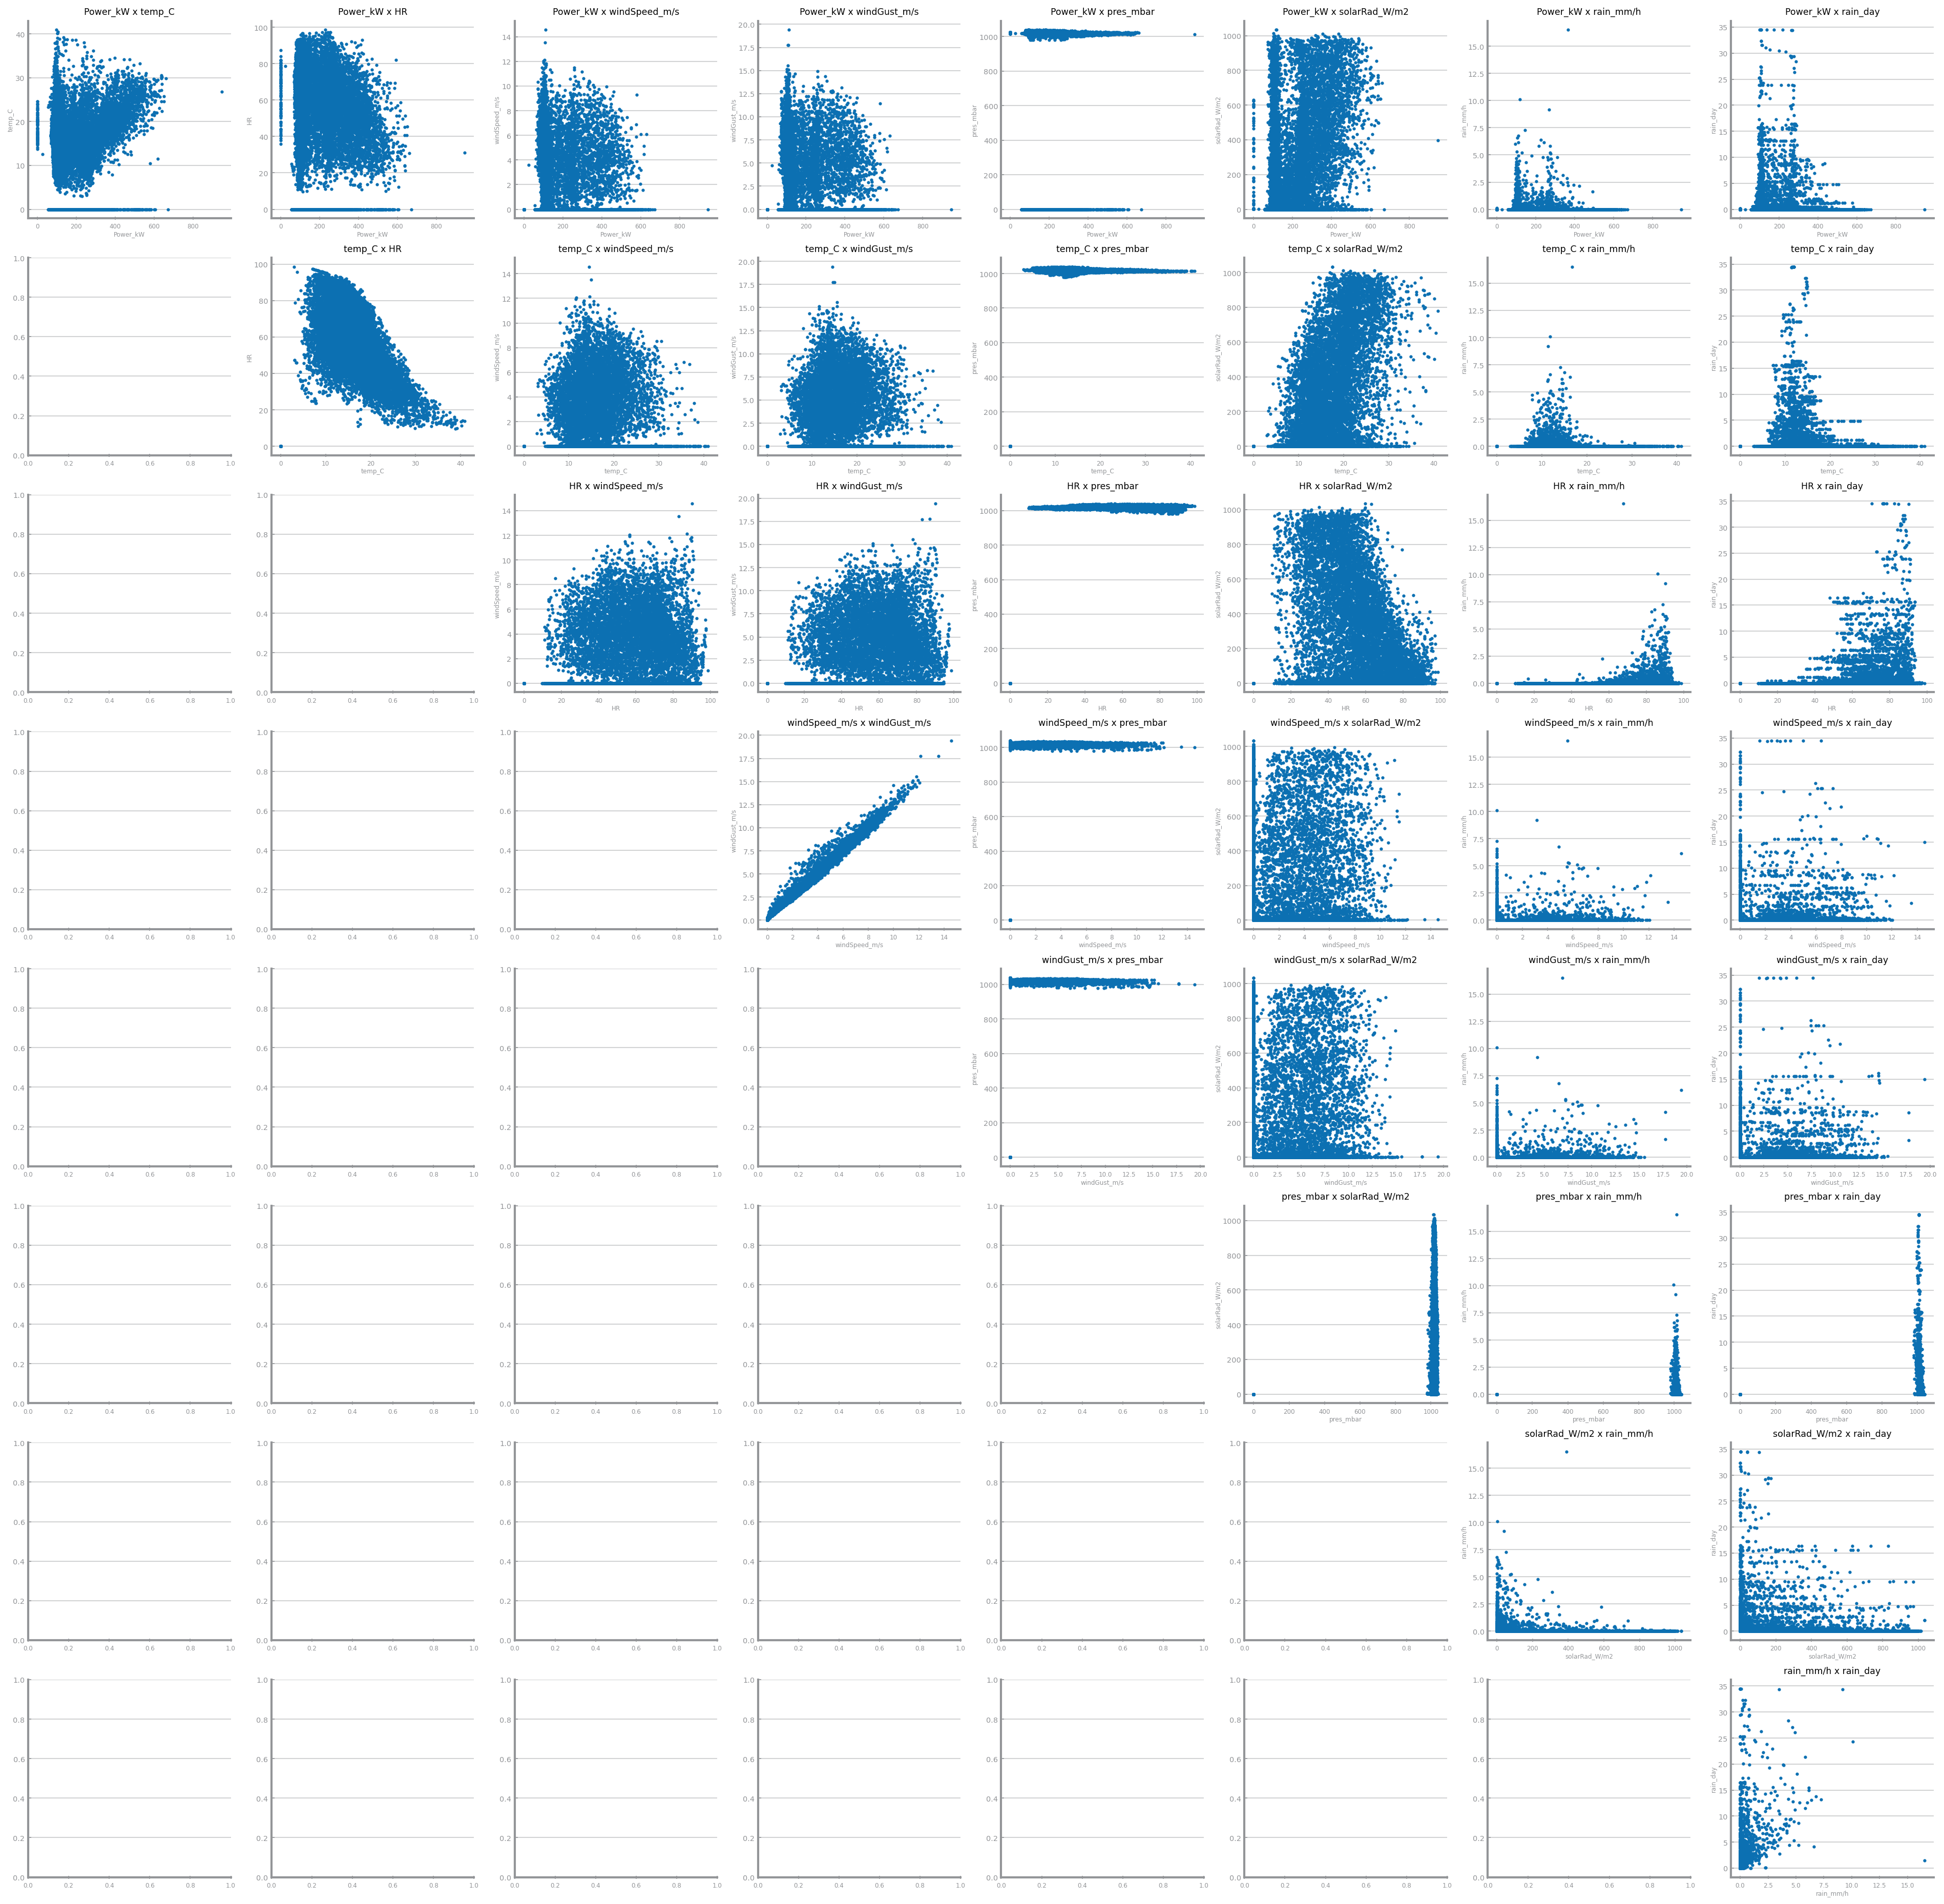

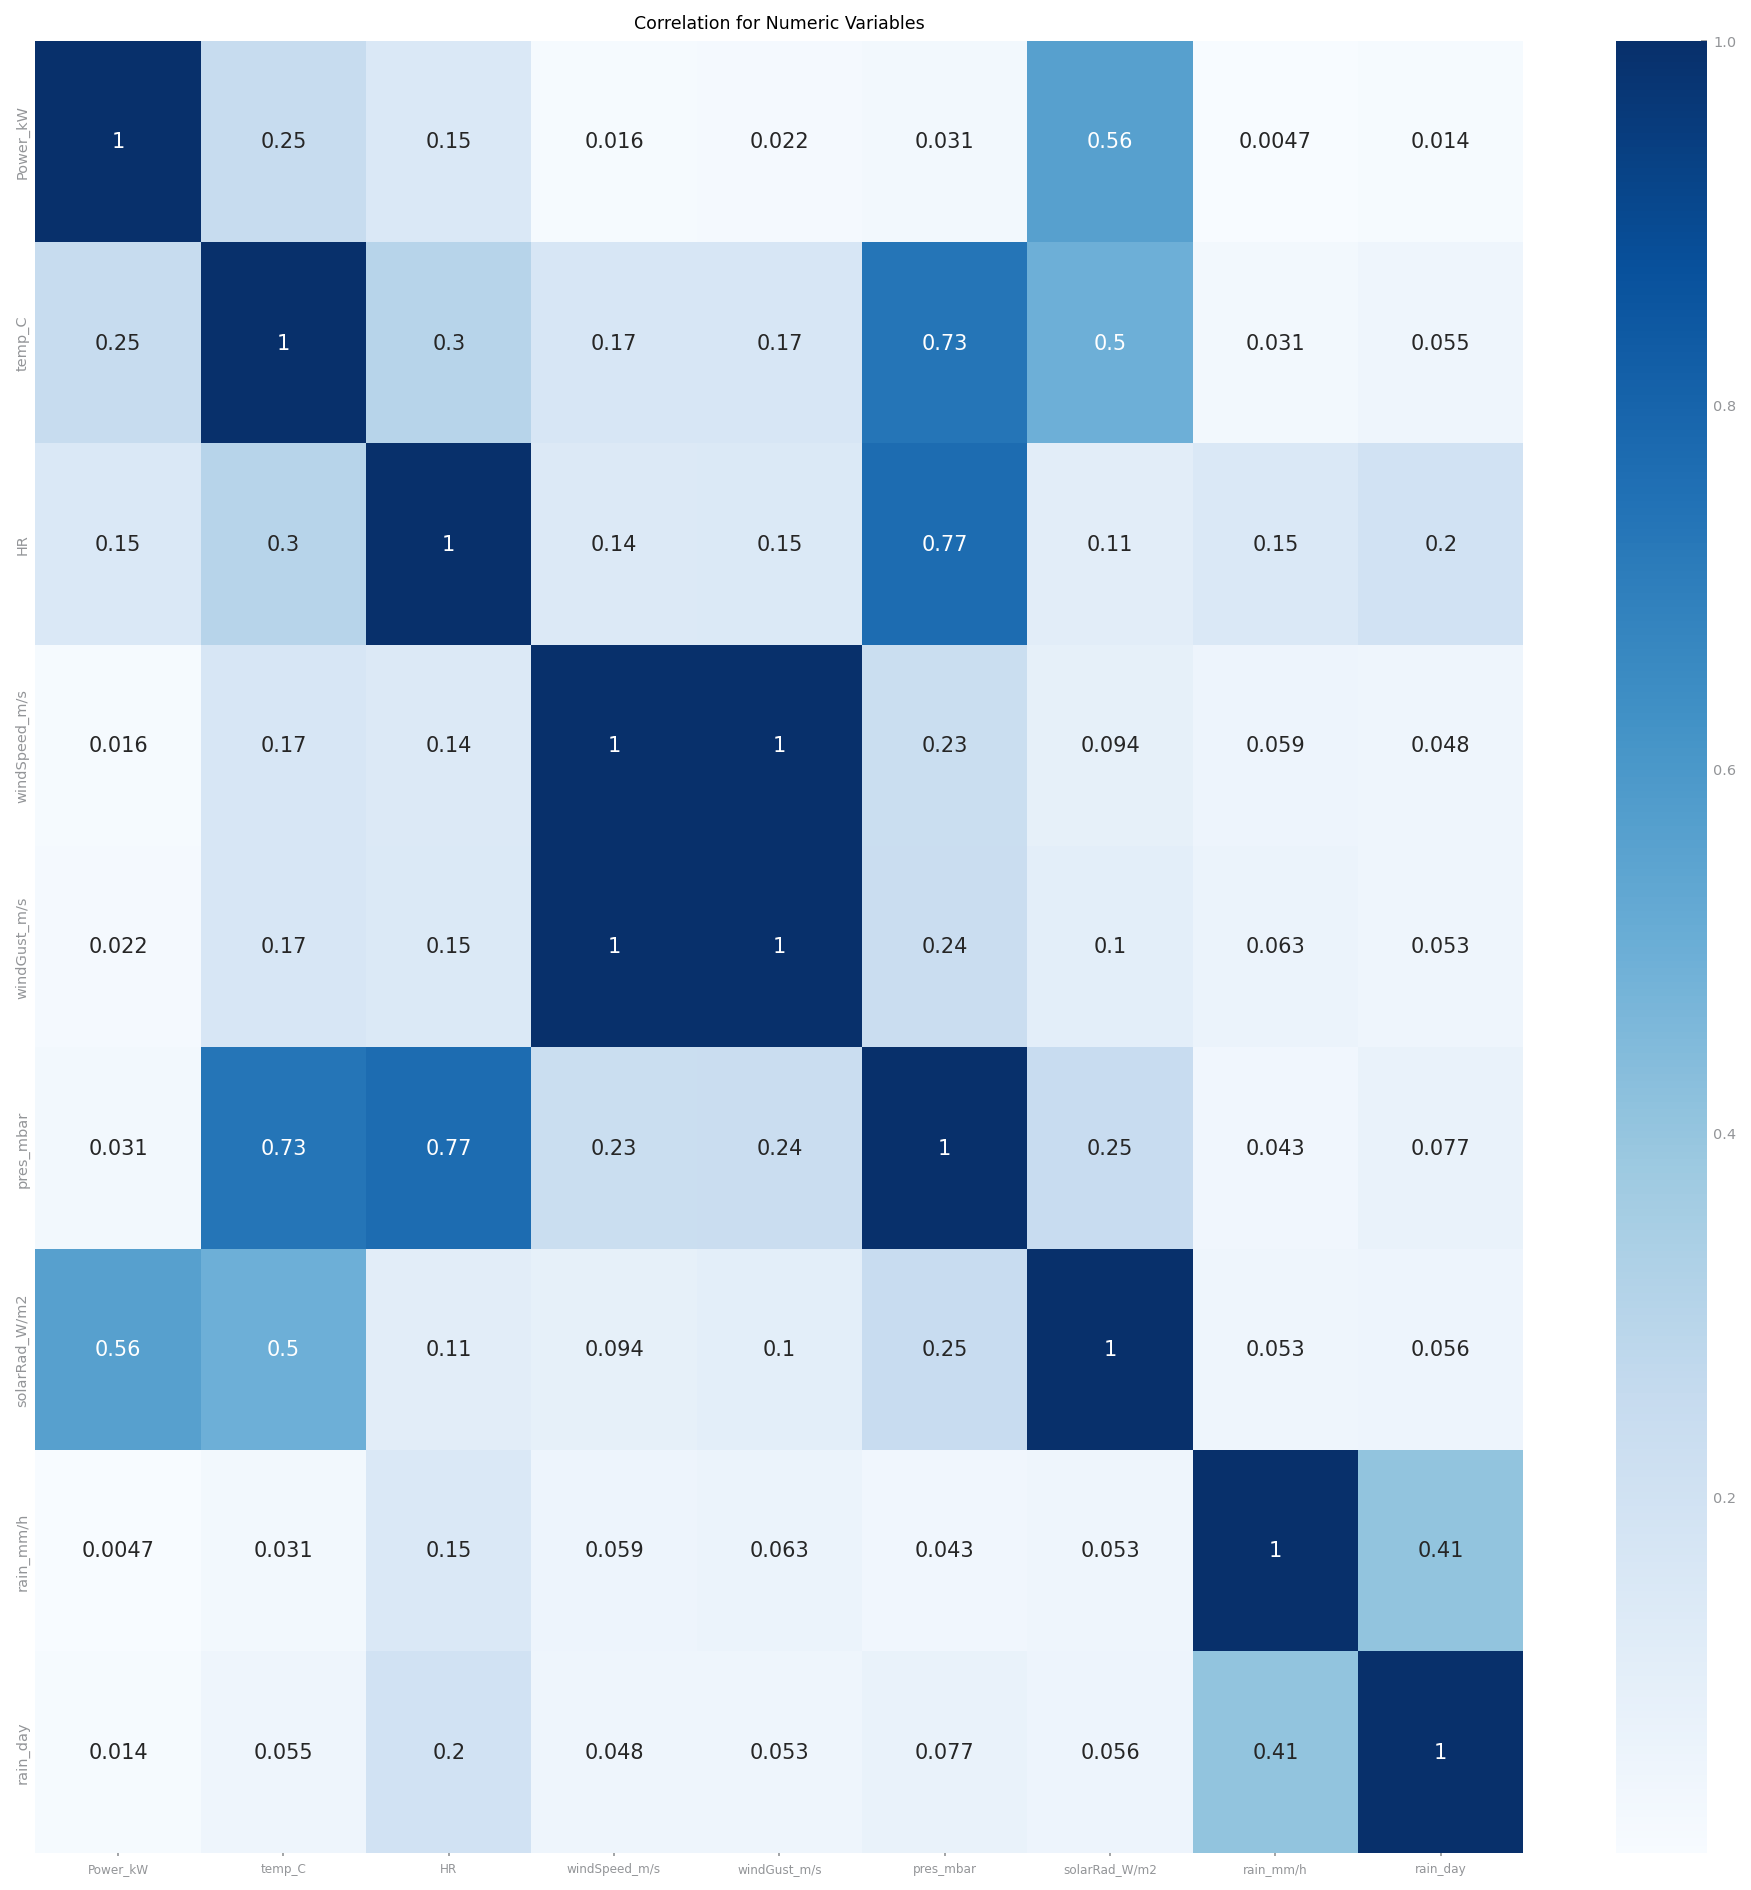

In [6]:
from ds_tools.profiling import show_histograms_numeric, show_sparsity, show_heatmap

show_histograms_numeric(df)
show_sparsity(df)
show_heatmap(df)

## Closer look at Correlations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


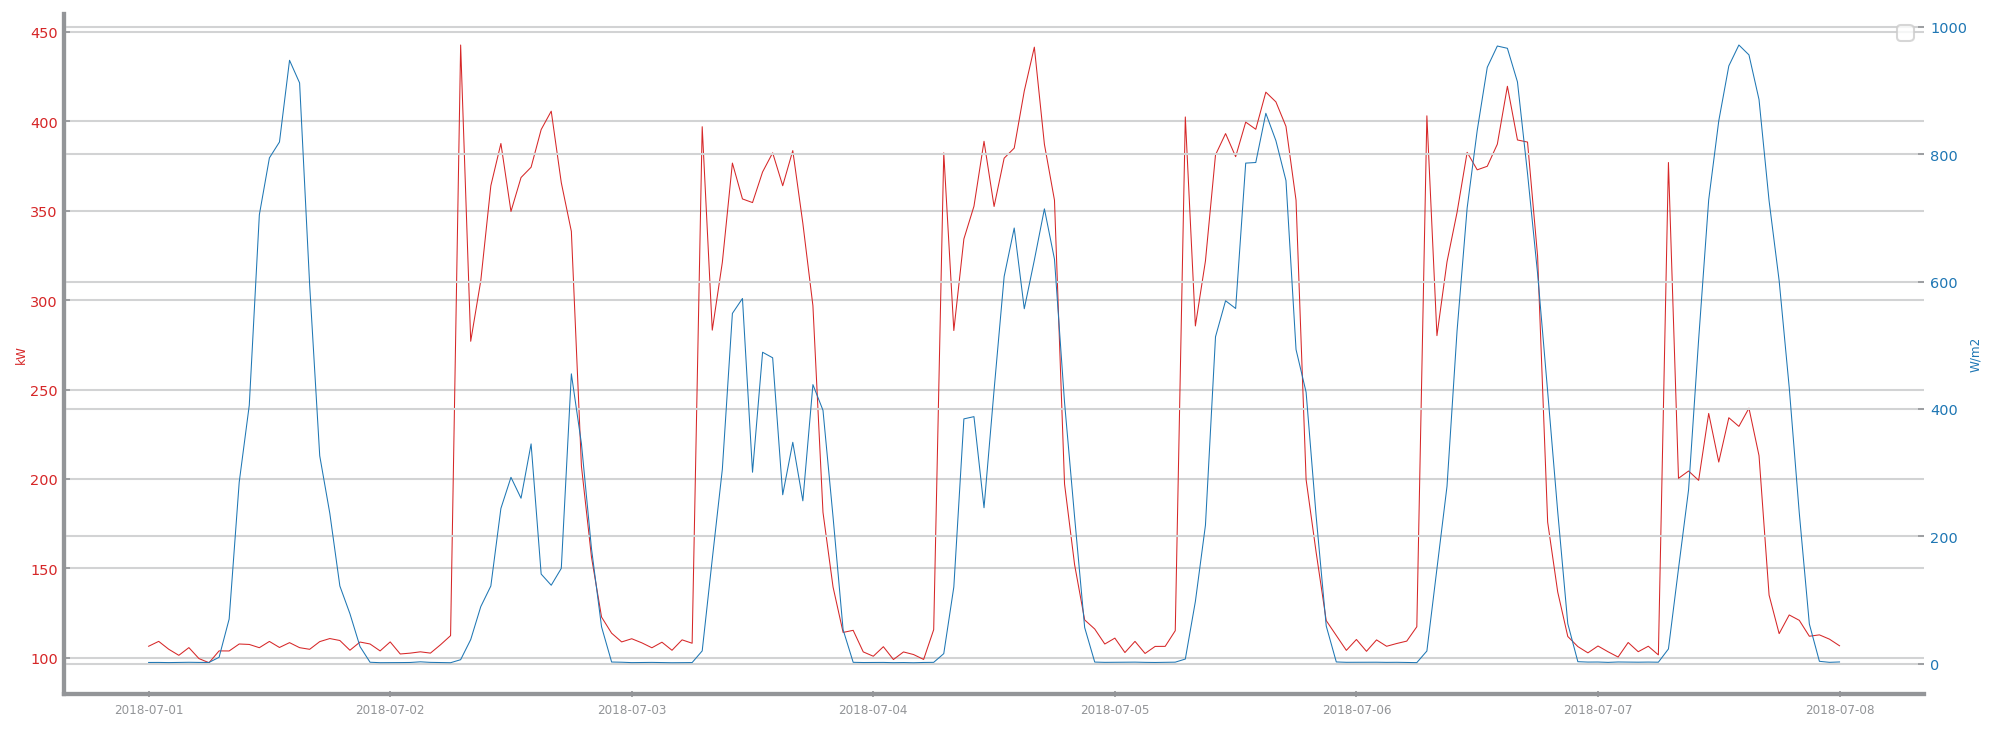

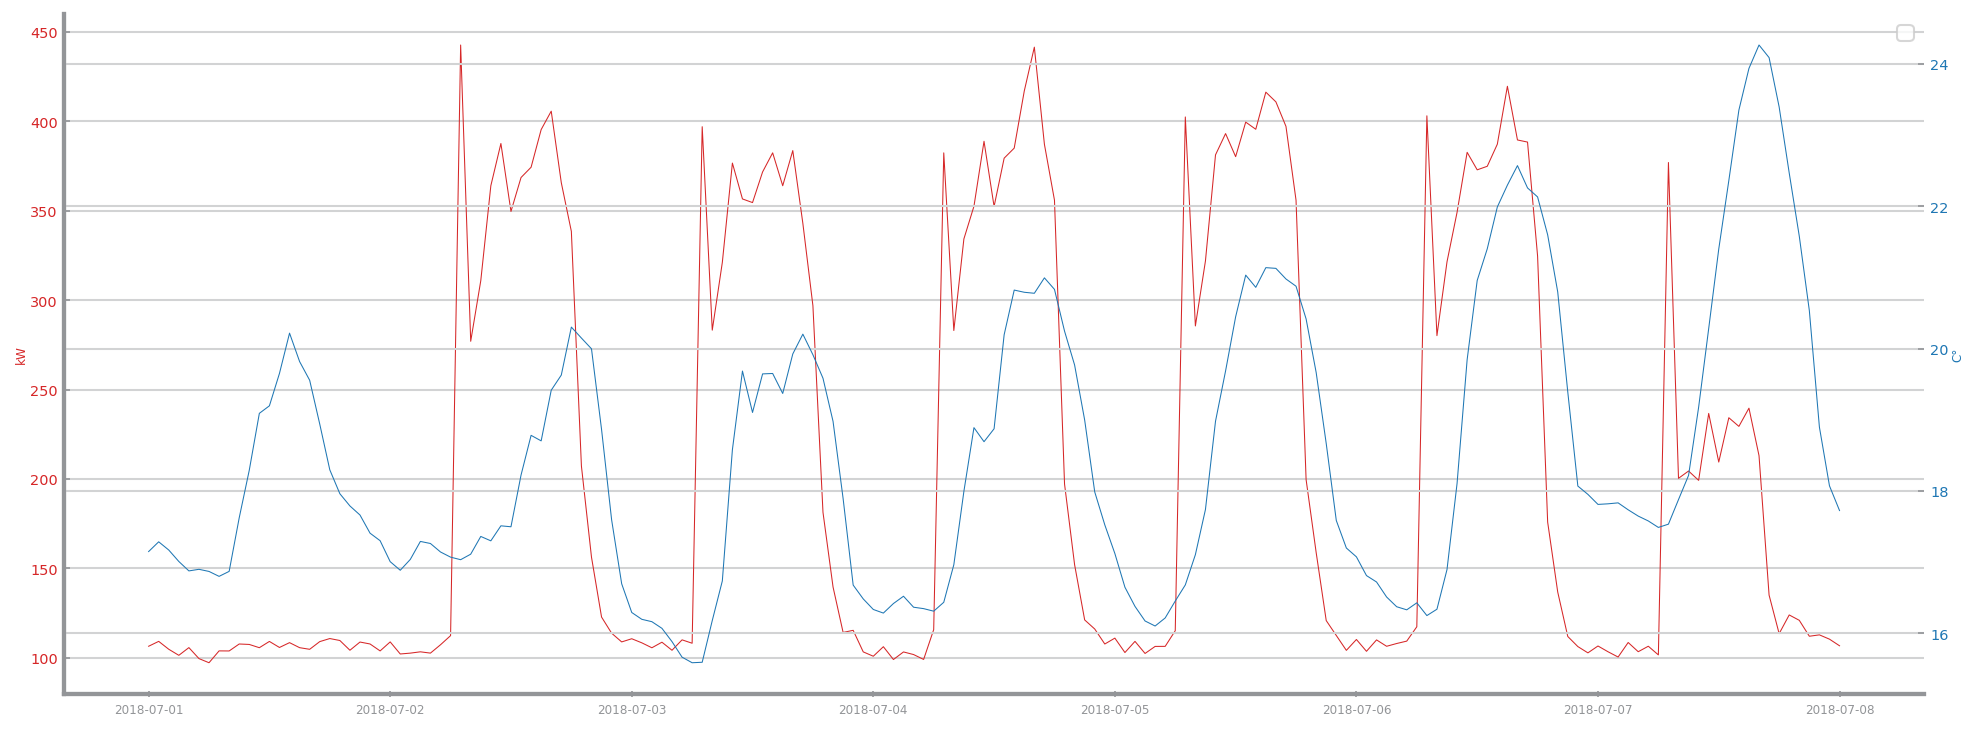

In [7]:
from datetime import datetime

start = datetime(year=2018, month=7, day=1)
end = datetime(year=2018, month=7, day=8)
plot_timeseries(df, columns=['Power_kW', 'solarRad_W/m2'], y_labels=['kW', 'W/m2'], start=start, end=end)
plot_timeseries(df, columns=['Power_kW', 'temp_C'], y_labels=['kW', 'C°'], start=start, end=end)

## Decompostion of Seasonalilty and Trends

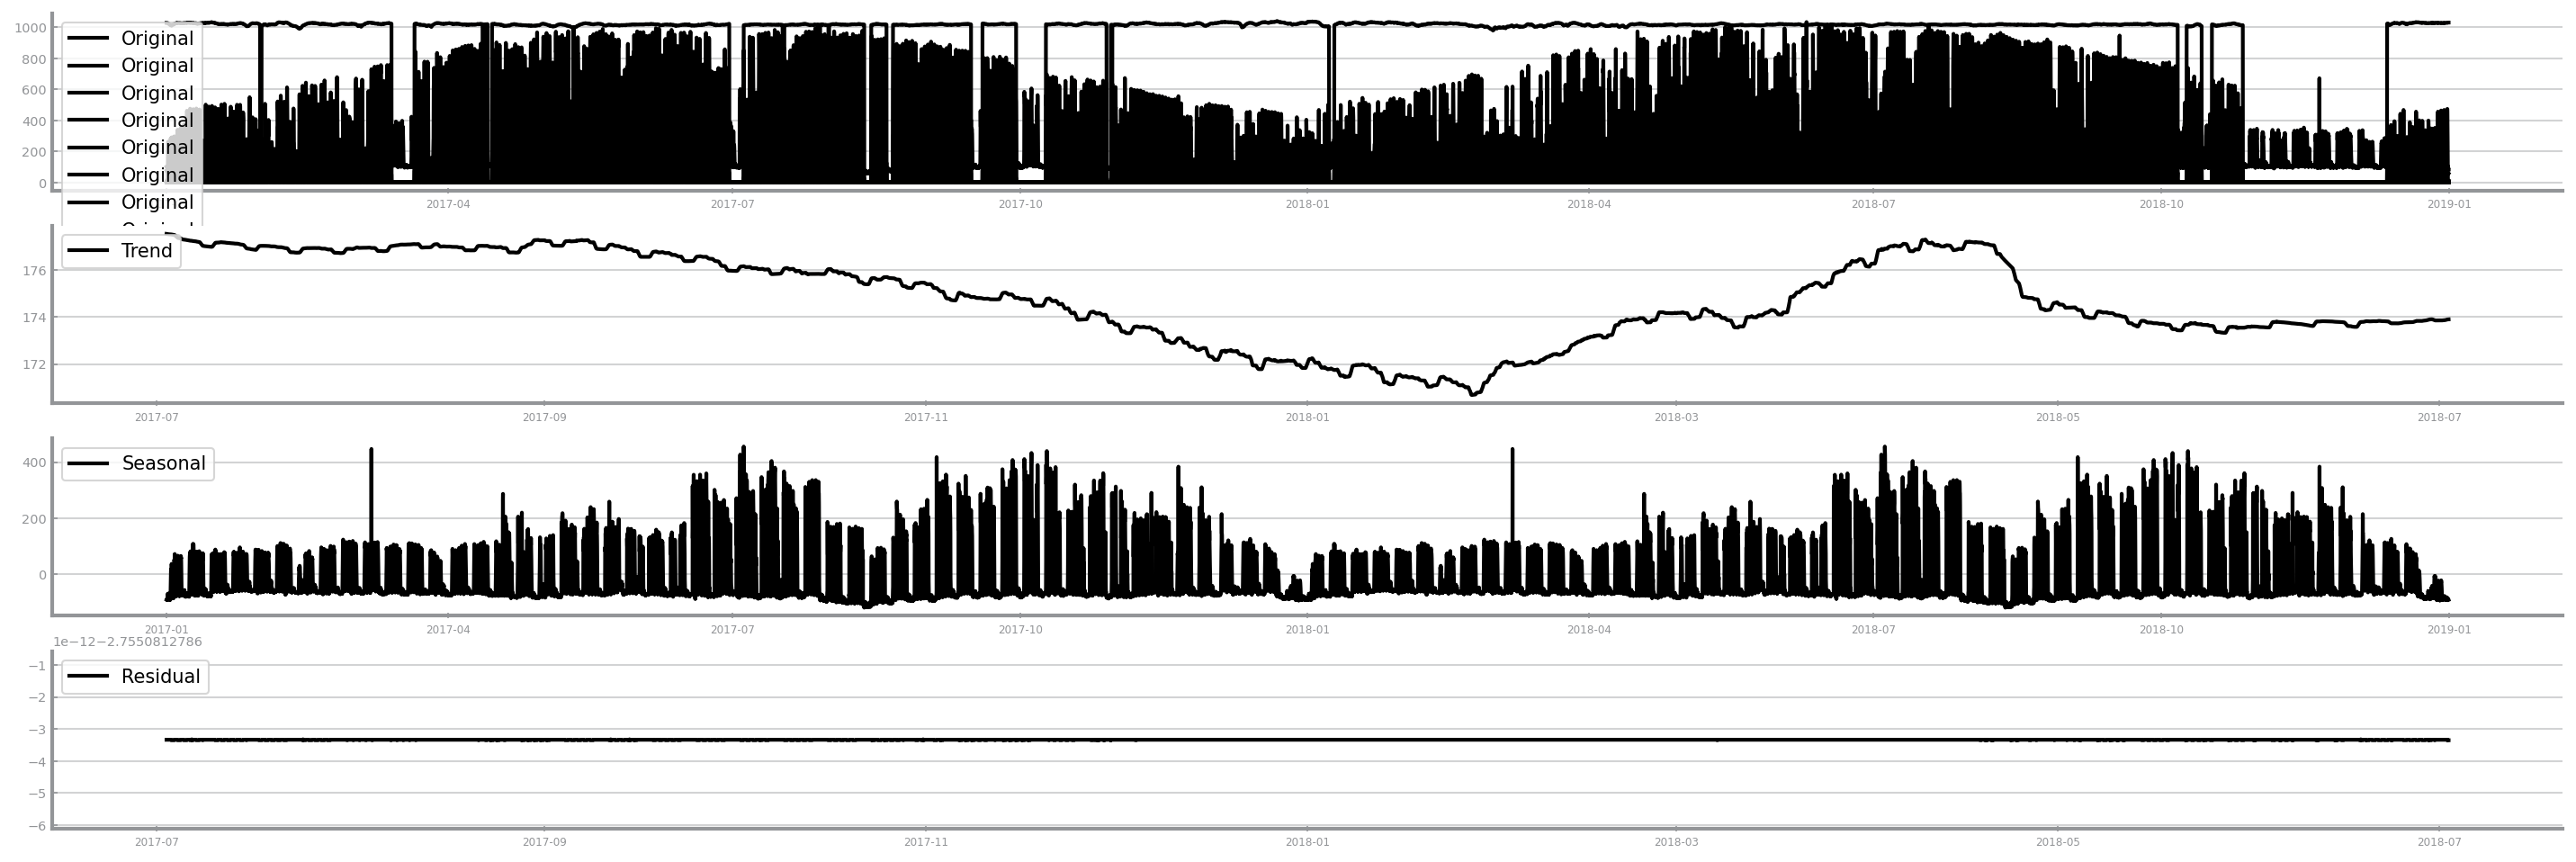

In [8]:
from ds_tools.profiling import plot_seasonal_decompose

plot_seasonal_decompose(df, column='Power_kW')

### Check Autocorrelation

Checking the correlation of the time series to itsef within a certain number of lags in the past.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

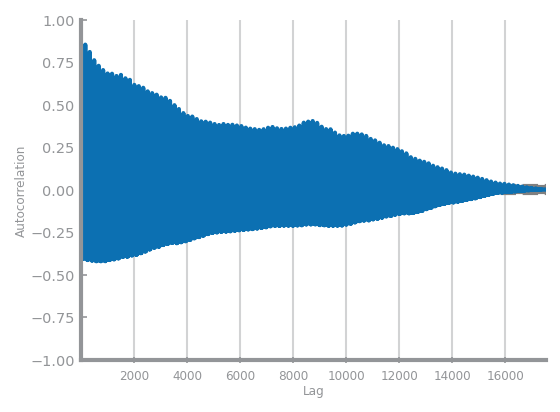

In [9]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Power_kW'])

## Clustering

### Scale Data

In [10]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

data_bool = df['holiday']
data_numeric = df.drop(columns=['holiday'])
min_max_scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data_numeric)
tmp_min_max = DataFrame(min_max_scaler.transform(data_numeric), index=df.index, columns=data_numeric.columns)

df_scaled = concat([tmp_min_max,  data_bool], axis=1)

df_scaled.head()

,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,rain_day,holiday
2017-01-01 00:00:00,0.106445,0.212791,0.756401,0.146757,0.194394,0.989820,0.001125,0.0,0.0,1
2017-01-01 01:00:00,0.104591,0.207178,0.760456,0.160336,0.166313,0.989820,0.001326,0.0,0.0,1
2017-01-01 02:00:00,0.104048,0.192232,0.777271,0.190567,0.180345,0.988938,0.001529,0.0,0.0,1
2017-01-01 03:00:00,0.107106,0.176002,0.815632,0.232290,0.215976,0.988858,0.001275,0.0,0.0,1
2017-01-01 04:00:00,0.103987,0.166355,0.824335,0.239606,0.224613,0.988858,0.001518,0.0,0.0,1


In [11]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=3).fit(df_scaled)

df.tail()

model = KMeans(n_clusters=3).fit(df)
pred = model.labels_
print(model.score)
pred

<bound method KMeans.score of KMeans(n_clusters=3)>


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

# Feature Engineering

## Feature Selection

## Feature Generation

#### Date Components to Dataframe

In [12]:
# add weekend information to dataframe
df['weekend'] = where(df.index.weekday > 4, 1, 0)

# extract date and time
df['day'] = [date.day for date in df.index]
df['month'] = [date.month for date in df.index]
df['year'] = [date.year for date in df.index]
df['hour'] = [date.hour for date in df.index]

df.head()

,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,rain_day,holiday,weekend,day,month,year,hour
2017-01-01 00:00:00,100.810001,8.720000,74.600000,2.138000,3.774000,1029.000000,1.163000,0.0,0.0,1,1,1,1,2017,0
2017-01-01 01:00:00,99.054135,8.490000,75.000000,2.335833,3.228833,1029.000000,1.371250,0.0,0.0,1,1,1,1,2017,1
2017-01-01 02:00:00,98.539567,7.877500,76.658333,2.776250,3.501250,1028.083333,1.581250,0.0,0.0,1,1,1,1,2017,2
2017-01-01 03:00:00,101.435784,7.212417,80.441667,3.384083,4.193000,1028.000000,1.318083,0.0,0.0,1,1,1,1,2017,3
2017-01-01 04:00:00,98.481664,6.817083,81.300000,3.490667,4.360667,1028.000000,1.569750,0.0,0.0,1,1,1,1,2017,4


# Modeling

As we are supposed to predict many hours, days or months ahead and our dataset consists of many variables, we have need to design a multivariate multi-step time series forecasting model.

The data is split into training and testing data.
90% of the data is used dor training and 10% for testing and is also the lenght of the forecast.

In [21]:
# split into train and test
from ds_tools.utils import split_timeseries

# define where to start
start = datetime(year=2018, month=7, day=1)
end = datetime(year=2018, month=7, day=12)

df = df[start:end]
train, test = split_timeseries(df, train_size=0.9)

### Baseline Model
Using two models for benchmarking

1. AutoML model from Meta (Facebook) called Prophet
2. Simple ARIMA Model

In [14]:
%%capture
#from ds_tools.time_series_models import prophet_auto_ml
#prediction_prophet = prophet_auto_ml(timestamp=train.index, prediction_variable=train.values, holidays=holidays, predict_period=PREDICT_PERIOD)

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from ds_tools.graphing.charts import plot_forecasting
import matplotlib.pyplot as plt

model = SARIMAX(train['Power_kW'], order=(0,0,1), seasonal_order =(1, 1, 1, 24))
result = model.fit()

prediction = result.predict(start=len(train), end=len(df)-1)

/Users/tobiassteggemann/energy-services-project-py/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/tobiassteggemann/energy-services-project-py/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21718D+00    |proj g|=  1.01652D-01

At iterate    5    f=  5.18871D+00    |proj g|=  4.94500D-02

At iterate   10    f=  5.17775D+00    |proj g|=  9.18827D-03

At iterate   15    f=  5.08544D+00    |proj g|=  1.15000D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   1.578D-05   5.085D+00
  F =   5.0853114028547699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


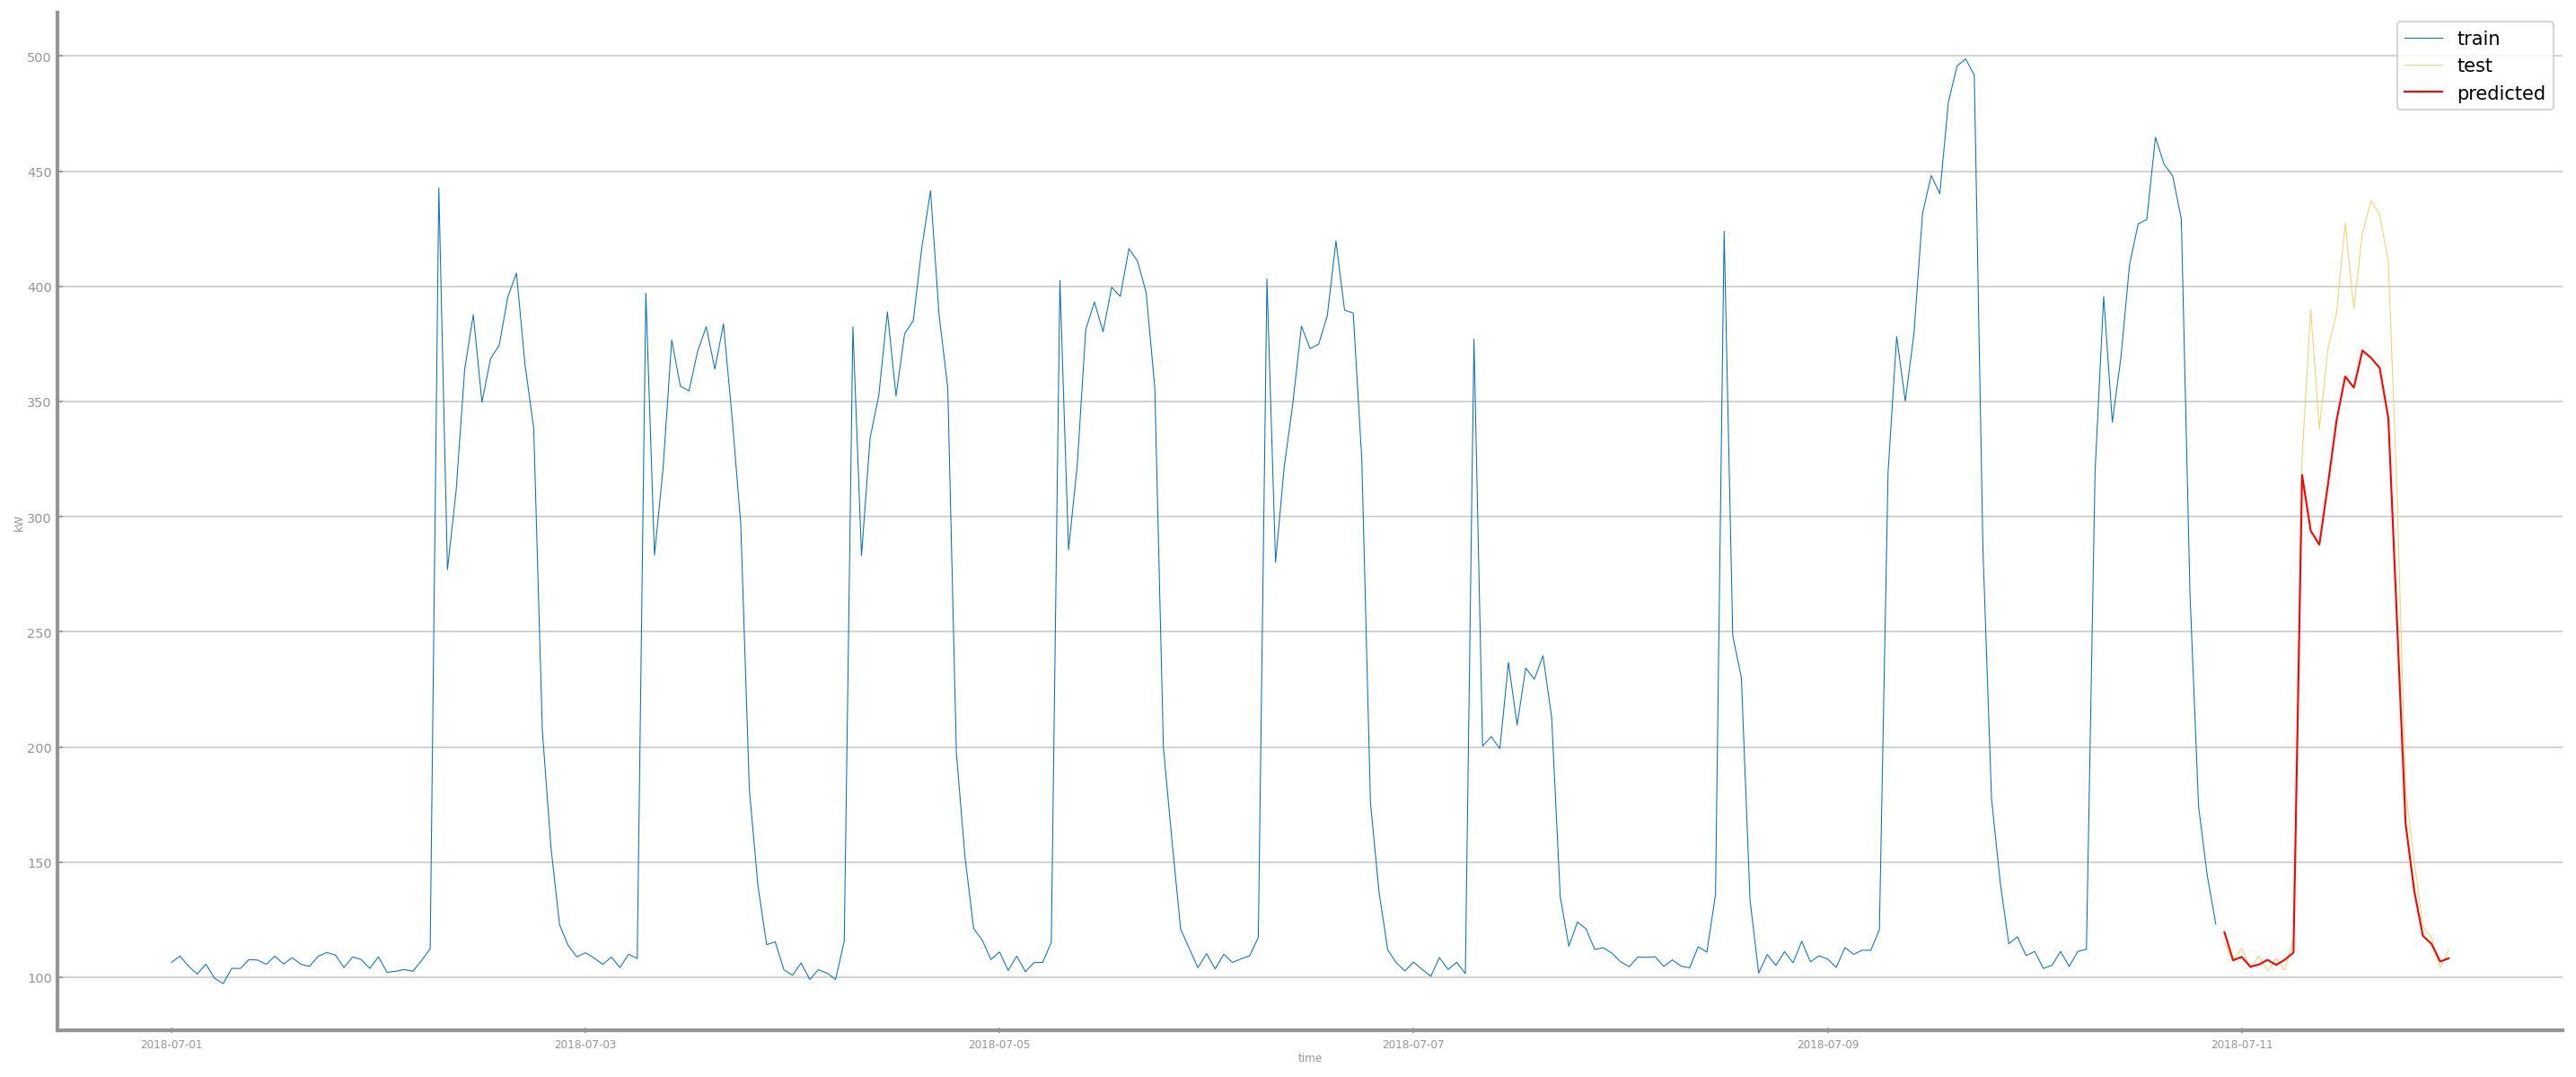

In [23]:
from ds_tools.graphing.charts import plot_forecasting

plot_forecasting(train=train['Power_kW'], test=test['Power_kW'], pred=prediction, x_label='time', y_label='kW')

# Model Evaluation

Using MAPE (Mean absolute percentage error) to Evaluate Models